In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim


In [2]:
from tqdm import tqdm
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:01m0:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.2 MB/s eta 0:00:0000:01m00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [2]:
import os
from glob import glob

hazy_dir = '/kaggle/input/ai-project/hazy'
clean_dir = '/kaggle/input/ai-project/clear'

hazy_images = sorted(glob(os.path.join(hazy_dir, '*.png')))
clean_images = sorted(glob(os.path.join(clean_dir, '*.png')))

# Create a dictionary of clean images
clean_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in clean_images}

matched_pairs = []
for hazy_path in hazy_images:
    hazy_name = os.path.basename(hazy_path)
    base_id = hazy_name.split('_')[0]  # Extract number before underscore

    if base_id in clean_dict:
        matched_pairs.append((hazy_path, clean_dict[base_id]))

print(f"Found {len(matched_pairs)} matched hazy-clean image pairs.")


Found 13990 matched hazy-clean image pairs.


In [3]:
from sklearn.model_selection import train_test_split

train_pairs, test_pairs = train_test_split(matched_pairs, test_size=0.1, random_state=42)

print(f"Training pairs: {len(train_pairs)}, Testing pairs: {len(test_pairs)}")


Training pairs: 12591, Testing pairs: 1399


In [4]:
# Define custom dataset class
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import cv2
import torch

class DehazeDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        hazy_path, clean_path = self.pairs[idx]
        hazy = cv2.imread(hazy_path)
        clean = cv2.imread(clean_path)

        hazy = cv2.cvtColor(hazy, cv2.COLOR_BGR2RGB)
        clean = cv2.cvtColor(clean, cv2.COLOR_BGR2RGB)

        hazy = self.transform(hazy)
        clean = self.transform(clean)

        return hazy, clean


In [5]:
# Prepare dataloaders
from torch.utils.data import DataLoader

batch_size = 8

train_dataset = DehazeDataset(train_pairs)
test_dataset = DehazeDataset(test_pairs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetDehaze(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetDehaze, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True),
            )

        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
                nn.LeakyReLU(0.2, inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 32)
        self.encoder2 = conv_block(32, 64)
        self.encoder3 = conv_block(64, 128)
        self.encoder4 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            conv_block(256, 512),
            nn.Dropout(0.3)  # Regularization for better generalization
        )

        self.upconv4 = up_block(512, 256)
        self.decoder4 = conv_block(512, 256)
        self.upconv3 = up_block(256, 128)
        self.decoder3 = conv_block(256, 128)
        self.upconv2 = up_block(128, 64)
        self.decoder2 = conv_block(128, 64)
        self.upconv1 = up_block(64, 32)
        self.decoder1 = conv_block(64, 32)

        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = self.decoder4(torch.cat([d4, e4], dim=1))
        d3 = self.upconv3(d4)
        d3 = self.decoder3(torch.cat([d3, e3], dim=1))
        d2 = self.upconv2(d3)
        d2 = self.decoder2(torch.cat([d2, e2], dim=1))
        d1 = self.upconv1(d2)
        d1 = self.decoder1(torch.cat([d1, e1], dim=1))

        return x + self.final(d1)  # Residual output for better detail retention


In [7]:
# Initialize model, optimizer, loss
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

model = UNetDehaze().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


In [8]:
# Improved training loop
from tqdm import tqdm

def train_model(model, train_loader, optimizer, criterion, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

        for hazy, clean in loop:
            hazy, clean = hazy.to(device), clean.to(device)

            optimizer.zero_grad()
            output = model(hazy)
            loss = criterion(output, clean)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


In [9]:
train_model(model, train_loader, optimizer, criterion, num_epochs=20)


Epoch 1, Loss: 0.0122


Epoch 2, Loss: 0.0070


Epoch 3, Loss: 0.0056


Epoch 4, Loss: 0.0046


Epoch 5, Loss: 0.0039


Epoch 6, Loss: 0.0033


Epoch 7, Loss: 0.0029


Epoch 8, Loss: 0.0025


Epoch 9, Loss: 0.0022


Epoch 10, Loss: 0.0020


Epoch 11, Loss: 0.0018


Epoch 12, Loss: 0.0017


Epoch 13, Loss: 0.0017


Epoch 14, Loss: 0.0015


Epoch 15, Loss: 0.0014


Epoch 16, Loss: 0.0013


Epoch 17, Loss: 0.0013


Epoch 18, Loss: 0.0013


Epoch 19, Loss: 0.0012


Epoch 20, Loss: 0.0011


In [10]:
# Saving the model!!!

torch.save(model.state_dict(), "/kaggle/working/dehaze_unet.pth")
print("Model saved to /kaggle/working/dehaze_unet.pth")


Model saved to /kaggle/working/dehaze_unet.pth


In [11]:
# Load the model
model.load_state_dict(torch.load("/kaggle/working/dehaze_unet.pth", map_location=device))
model.to(device)
print("Model loaded successfully.")


Model loaded successfully.


In [12]:
from tqdm import tqdm
import cv2
from skimage.metrics import structural_similarity as ssim

def evaluate_model(model, test_loader):
    model.eval()
    total_psnr = 0.0
    total_ssim = 0.0
    psnr_list = []
    ssim_list = []

    with torch.no_grad():
        for hazy, clean in tqdm(test_loader, desc="Evaluating"):
            hazy, clean = hazy.to(device), clean.to(device)
            output = model(hazy)

            output_np = output.squeeze().cpu().permute(1, 2, 0).numpy()
            clean_np = clean.squeeze().cpu().permute(1, 2, 0).numpy()

            output_np = (output_np * 255).clip(0, 255).astype('uint8')
            clean_np = (clean_np * 255).clip(0, 255).astype('uint8')

            psnr_val = cv2.PSNR(output_np, clean_np)
            ssim_val = ssim(output_np, clean_np, channel_axis=-1)

            psnr_list.append(psnr_val)
            ssim_list.append(ssim_val)

            total_psnr += psnr_val
            total_ssim += ssim_val

    avg_psnr = total_psnr / len(test_loader)
    avg_ssim = total_ssim / len(test_loader)
    print(f"\n✅ Test PSNR: {avg_psnr:.2f} dB | SSIM: {avg_ssim:.4f}")

    return psnr_list, ssim_list


In [13]:
psnr_values, ssim_values = evaluate_model(model, test_loader)


Evaluating: 100%|██████████| 1399/1399 [01:27<00:00, 15.91it/s]


✅ Test PSNR: 31.13 dB | SSIM: 0.9601


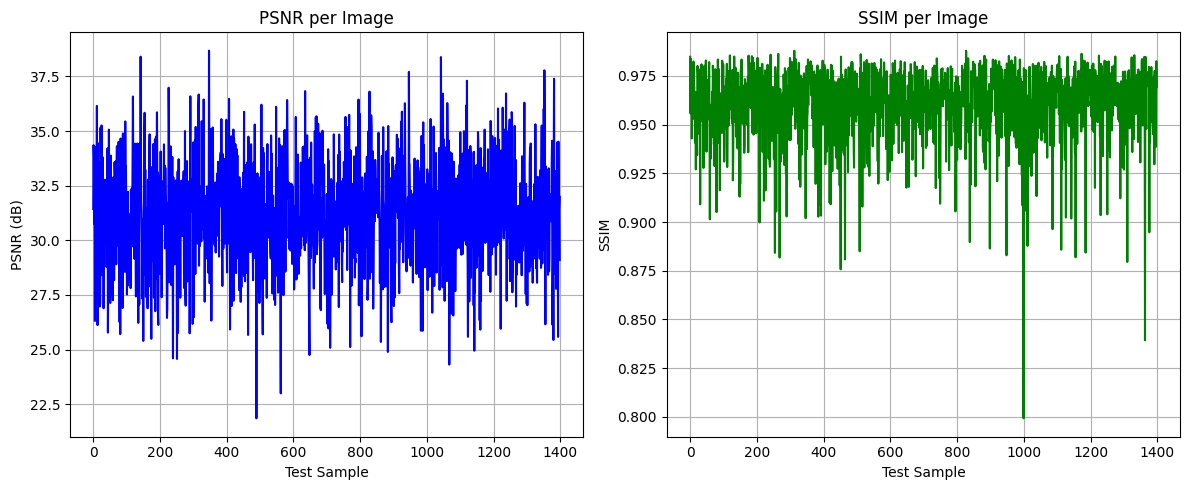

In [16]:
# Plot the evaluation metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(psnr_values, label='PSNR', color='blue')
plt.xlabel('Test Sample')
plt.ylabel('PSNR (dB)')
plt.title('PSNR per Image')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ssim_values, label='SSIM', color='green')
plt.xlabel('Test Sample')
plt.ylabel('SSIM')
plt.title('SSIM per Image')
plt.grid(True)

plt.tight_layout()
plt.show()


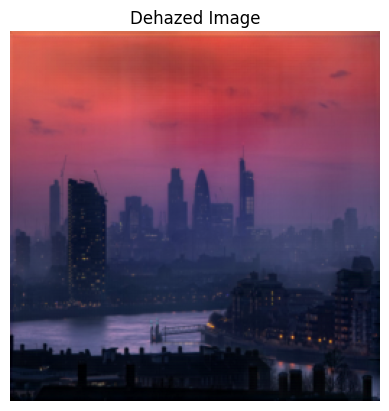

In [17]:
# Custom image(change path)
from PIL import Image

def dehaze_custom_image(image_path, model, intensity=1.0):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    hazy = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(hazy)

    # Intensity control (1.0 = original output)
    output = (intensity * output + (1 - intensity) * hazy).clamp(0, 1)

    output_image = output.squeeze().cpu().permute(1, 2, 0).numpy()
    plt.imshow(output_image)
    plt.title("Dehazed Image")
    plt.axis('off')
    plt.show()

# Example
dehaze_custom_image("/kaggle/input/test456/test2.jpg", model, intensity=0.9)


In [ ]:
# Loading the saved model
import torch
import torch.nn as nn

# Define your UNet or whatever architecture you used
class UNet(nn.Module):
    # (Use your actual model code here)
    def __init__(self):
        super(UNet, self).__init__()
        # define layers here
    def forward(self, x):
        # define forward pass here
        return x  # placeholder

# Instantiate and load model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

model_path = "/kaggle/input/mymodel/pytorch/default/1/dehaze_unet (1).pth"  
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


In [ ]:
# Load the test dataset
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Example dataset class (adjust path & transforms accordingly)
class RESIDETestDataset(Dataset):
    def __init__(self, hazy_dir, clean_dir, transform=None):
        self.hazy_images = sorted(os.listdir(hazy_dir))
        self.clean_images = sorted(os.listdir(clean_dir))
        self.hazy_dir = hazy_dir
        self.clean_dir = clean_dir
        self.transform = transform

    def __len__(self):
        return len(self.hazy_images)

    def __getitem__(self, idx):
        hazy_path = os.path.join(self.hazy_dir, self.hazy_images[idx])
        clean_path = os.path.join(self.clean_dir, self.clean_images[idx])

        hazy = Image.open(hazy_path).convert('RGB')
        clean = Image.open(clean_path).convert('RGB')

        if self.transform:
            hazy = self.transform(hazy)
            clean = self.transform(clean)

        return hazy, clean

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # or your image size
    transforms.ToTensor(),
])

hazy_test_dir = "/kaggle/input/ai-project/hazy"   # Adjust folder names accordingly
clean_test_dir = "/kaggle/input/ai-project/clear"

test_dataset = RESIDETestDataset(hazy_test_dir, clean_test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
# EVALUATE
import cv2
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()
    psnr_values = []
    ssim_values = []

    with torch.no_grad():
        for hazy, clean in tqdm(dataloader, desc="Evaluating"):
            hazy, clean = hazy.to(device), clean.to(device)
            output = model(hazy)

            output_np = output.cpu().permute(0, 2, 3, 1).numpy()
            clean_np = clean.cpu().permute(0, 2, 3, 1).numpy()

            for i in range(output_np.shape[0]):
                out_img = np.clip(output_np[i] * 255, 0, 255).astype(np.uint8)
                clean_img = np.clip(clean_np[i] * 255, 0, 255).astype(np.uint8)

                psnr_val = cv2.PSNR(out_img, clean_img)
                ssim_val = ssim(out_img, clean_img, channel_axis=2)

                psnr_values.append(psnr_val)
                ssim_values.append(ssim_val)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")

    return psnr_values, ssim_values

psnr_list, ssim_list = evaluate_model(model, test_loader)


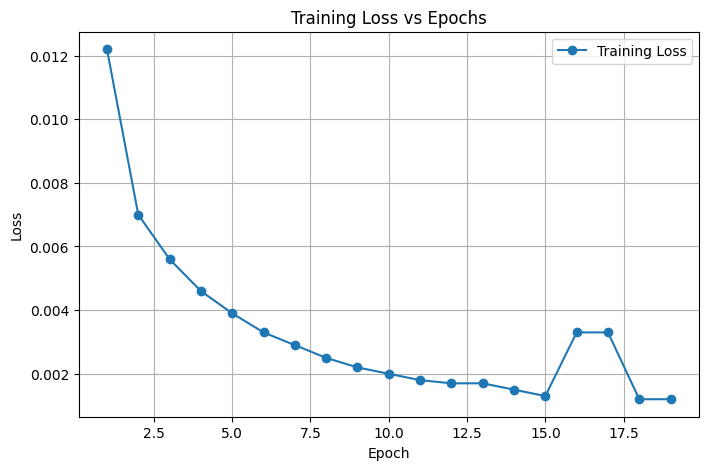

In [18]:
#Epochs vs training loss
import matplotlib.pyplot as plt

# Example loss list from training - replace with your actual saved losses
train_losses = [0.0122,0.0070,0.0056,0.0046,0.0039,0.0033,0.0029,0.0025,0.0022,0.0020,0.0018,0.0017,0.0017,0.0015,0.0013,0.0033,0.0033,0.0012,0.0012]
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
